# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `bill_depth_mm` using the other variables in the dataset.

**Dummify** all variables that require this.

In [1]:
pip install palmerpenguins

In [21]:
import pandas as pd
import numpy as np
from palmerpenguins import load_penguins
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.exceptions import ConvergenceWarning
from plotnine import *

In [3]:
penguins = load_penguins()
penguins = penguins.dropna()
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


Let's use the other variables to predict `bill_depth_mm`. Prepare your data and fit the following models on the entire dataset:

* Your best multiple linear regression model from before
* Two kNN models (for different values of K)
* A decision tree model

Create a plot like the right plot of Fig 1. in our `Model Validation` chapter with the training and test error plotted for each of your four models.

Which of your models was best?

In [4]:
# Elastic Net Model

X = penguins.drop(["bill_depth_mm"], axis = 1)
y = penguins["bill_depth_mm"]

# make_column_selector selects columns to dummify, and scale numerical
ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
     make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough" # keeps all variables
)

elastic_pipe = Pipeline(
  [
      ("preprocessing", ct),
      ("elastic_regression", ElasticNet())
      ])

parameter_grid = {'elastic_regression__alpha': [0.001, 0.01, 0.1, 1, 10],
                  'elastic_regression__l1_ratio':[0.2, 0.4, 0.6, 0.8, 1]}

gscv = GridSearchCV(elastic_pipe, parameter_grid, cv = 5, scoring='r2')

In [5]:
gscv_fitted = gscv.fit(X, y)

In [6]:
parameters = gscv_fitted.cv_results_['params']
scores = gscv_fitted.cv_results_['mean_test_score']

data = {
    'Parameters': parameters,
    'Scores': scores
}

df = pd.DataFrame(data)
df.sort_values(by = 'Scores', ascending = False).head()

#{'elastic_regression__alpha': 0.01, 'elastic_regression__l1_ratio': 1}

,Parameters,Scores
9,"{'elastic_regression__alpha': 0.01, 'elastic_r...",0.412983
0,"{'elastic_regression__alpha': 0.001, 'elastic_...",0.405574
1,"{'elastic_regression__alpha': 0.001, 'elastic_...",0.405456
2,"{'elastic_regression__alpha': 0.001, 'elastic_...",0.405046
4,"{'elastic_regression__alpha': 0.001, 'elastic_...",0.404870


In [7]:
elastic_pipeline_optimal = Pipeline(
  [("preprocessing", ct),
  ("elastic_regression", ElasticNet(alpha = 0.01, l1_ratio = 1))]
)

elastic_pipeline_fitted = elastic_pipeline_optimal.fit(X, y)

y_2 = elastic_pipeline_fitted.named_steps['elastic_regression'].coef_


In [14]:
warnings.simplefilter('ignore')

# K Nearest Neighbors Regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Multiple values for k
k1 = 2
k2 = 10
penguins['year'] = penguins['year'].astype(str)
# New column transformer for this data
ct1 = ColumnTransformer(
    [
        ('dummify', OneHotEncoder(sparse_output = False, handle_unknown = 'ignore'),
         make_column_selector(dtype_include=object)),
        ('standardize', StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder='passthrough'
)

# Creating a kNN pipeline
knn_pipe1 = Pipeline(
    [
        ('preprocessing', ct1),
        ('knn_regression', KNeighborsRegressor(n_neighbors = 5))
    ]
)

knn_pipe2 = Pipeline(
    [
        ('preprocessing', ct1),
        ('knn_regression', KNeighborsRegressor(n_neighbors = 20))
    ]
)
# Creating a dictionary of values for k
knn_dict = {'knn_regression__n_neighbors': [1, 5, 10, 20, 50, 100]}

# Cross validate over each k value
knn_grid_train = GridSearchCV(knn_pipe1, knn_dict, cv = 5, scoring = 'neg_mean_squared_error')
knn_grid1 = knn_grid_train.fit(X_train, y_train)
knn_grid_test = GridSearchCV(knn_pipe1, knn_dict, cv = 5, scoring = 'neg_mean_squared_error')
knn_grid2 = knn_grid_test.fit(X_test, y_test)
knn_grid_full = GridSearchCV(knn_pipe1, knn_dict, cv = 5, scoring = 'neg_mean_squared_error')
knn_grid3 = knn_grid_full.fit(X, y)

pd.DataFrame(data = {'K': knn_grid1.cv_results_['param_knn_regression__n_neighbors'],
                     'MSE train data': -knn_grid1.cv_results_['mean_test_score'],
                     'MSE test data': -knn_grid2.cv_results_['mean_test_score'],
                     'MSE full data': -knn_grid3.cv_results_['mean_test_score']})

,K,MSE train data,MSE test data,MSE full data
0,1,1.118938,0.808412,1.421694
1,5,0.802973,0.593116,1.191880
2,10,0.710848,0.617936,1.182909
3,20,0.751790,1.229122,1.335965
4,50,1.140706,3.021817,1.911282
5,100,2.241174,NaN,3.346643


In [11]:
# Decision tree pipeline
dt_pipeline = Pipeline(
    [
        ('preprocessing', ct1),
        ('dt_regression', DecisionTreeRegressor())
    ]
)

# Hyperparameter specification
parameters = {
    'dt_regression__max_depth': [1, 10, 100, 1000]
}

# Grid Search
dt_grid = GridSearchCV(dt_pipeline, parameters, cv = 5, scoring = 'neg_mean_squared_error')
dt_grid_fit = dt_grid.fit(X, y)

pd.DataFrame(data = {'Max Depth': dt_grid.cv_results_['param_dt_regression__max_depth'],
                     'MSE': -dt_grid_fit.cv_results_['mean_test_score']})

,Max Depth,MSE
0,1,1.325173
1,10,1.487495
2,100,1.550316
3,1000,1.597953


In [19]:
# Extracting training and test error for all four models

# Elastic net
elastic_pipeline_optimal.fit(X_train, y_train)
train_error_elastic = mean_squared_error(y_train, elastic_pipeline_optimal.predict(X_train))
test_error_elastic = mean_squared_error(y_test, elastic_pipeline_optimal.predict(X_test))

# Knn when k = 5
knn_pipe1.fit(X_train, y_train)
train_error_knn5 = mean_squared_error(y_train, knn_pipe1.predict(X_train))
test_error_knn5 = mean_squared_error(y_test, knn_pipe1.predict(X_test))

# Knn when k = 20
knn_pipe2.fit(X_train, y_train)
train_error_knn20 = mean_squared_error(y_train, knn_pipe2.predict(X_train))
test_error_knn20 = mean_squared_error(y_test, knn_pipe2.predict(X_test))

# Decision tree
dt_pipeline.fit(X_train, y_train)
train_error_tree = mean_squared_error(y_train, dt_pipeline.predict(X_train))
test_error_tree = mean_squared_error(y_test, dt_pipeline.predict(X_test))

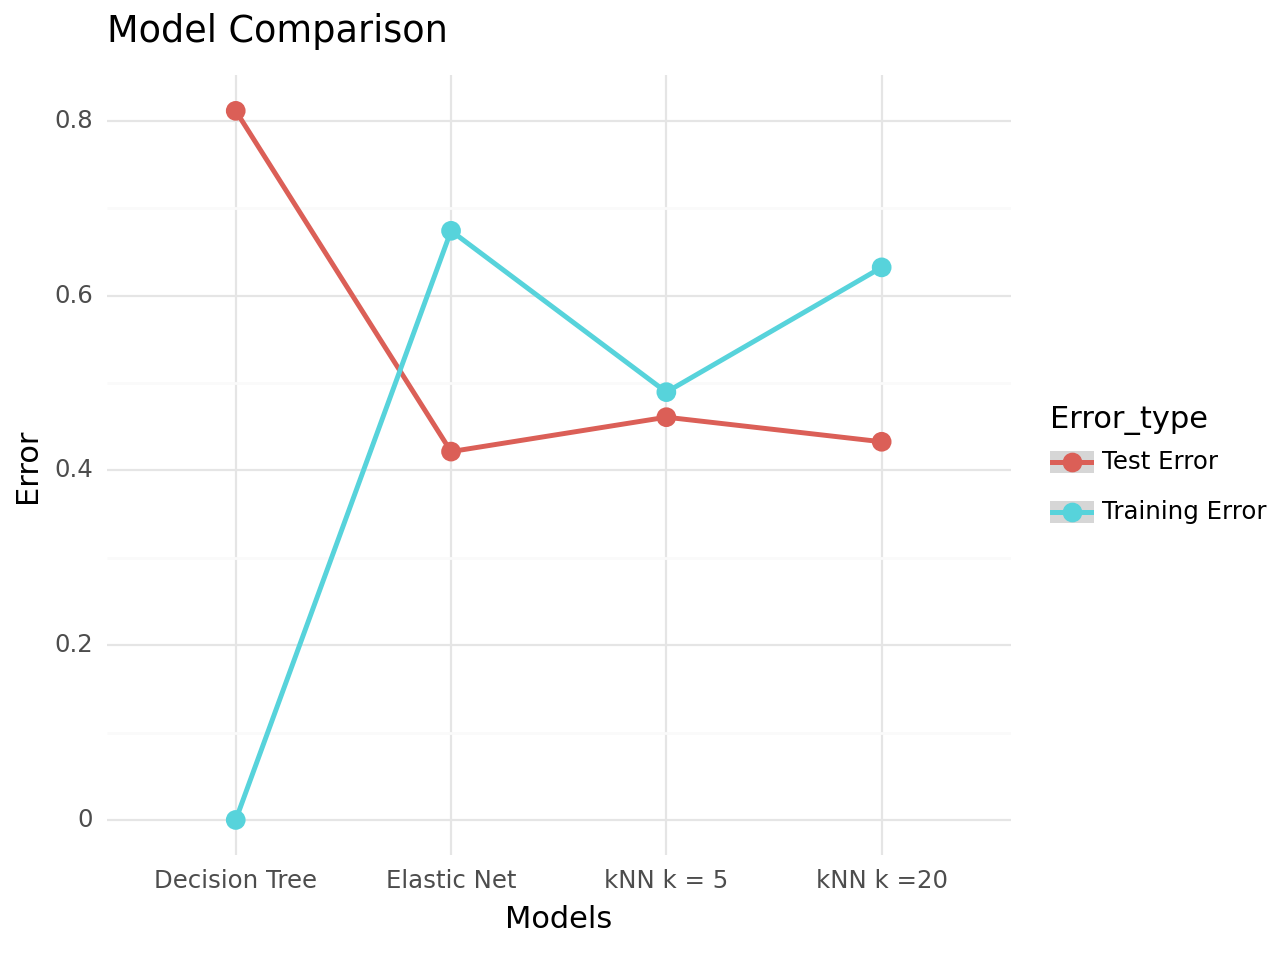

<Figure Size: (640 x 480)>

In [23]:
# Prepping to plot error
models = ['Elastic Net', 'kNN k = 5', 'kNN k =20', 'Decision Tree']
train_error = [train_error_elastic, train_error_knn5, train_error_knn20, train_error_tree]
test_error = [test_error_elastic, test_error_knn5, test_error_knn20, test_error_tree]

# Making a data frame for all models
data = pd.DataFrame({
    'Models': models * 2,
    'Errors': train_error + test_error,
    'Error_type': ['Training Error'] * len(models) + ['Test Error'] * len(models)
})

(ggplot(data, aes(x = 'Models',
                  y = 'Errors',
                  color = 'Error_type'))
+ geom_line(aes(group = 'Error_type'),
            size = 1)
+ geom_smooth(method = 'loess')
+ geom_point(size = 3)
+ labs(title = 'Model Comparison',
       x = 'Models',
       y = 'Error')
+ theme_minimal()
)

Looking at the plot of training error and test error figure above, I think the best model is the kNN model where k = 5. It produced the model with the most consistent and, on average, the lowest error. It appears flexible but not overfit.